In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Root directory for dataset
dataroot = "."

# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

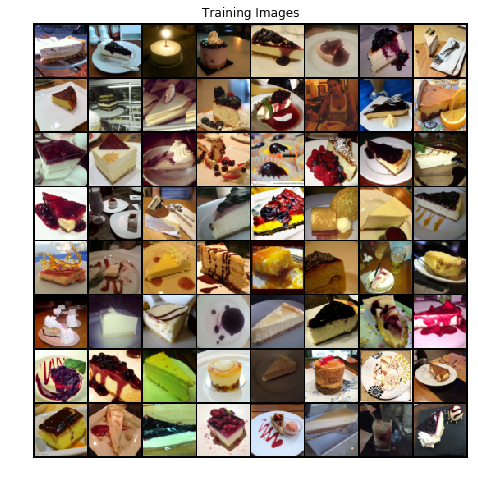

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])) #when creating dataset, the function checks the subfolder of given dataroot,
                               #so the images should be put in the subfolder
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory = True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False), 
            nn.Sigmoid()
        )
         #The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample 
         #because it lets the network learn its own pooling function

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/8]	Loss_D: 2.1215	Loss_G: 6.0428	D(x): 0.5390	D(G(z)): 0.6879 / 0.0044
[1/500][0/8]	Loss_D: 0.8073	Loss_G: 9.9718	D(x): 0.8474	D(G(z)): 0.3889 / 0.0001
[2/500][0/8]	Loss_D: 1.2222	Loss_G: 15.0305	D(x): 0.9309	D(G(z)): 0.6062 / 0.0000
[3/500][0/8]	Loss_D: 0.3136	Loss_G: 10.1955	D(x): 0.7764	D(G(z)): 0.0010 / 0.0001
[4/500][0/8]	Loss_D: 0.2078	Loss_G: 12.8797	D(x): 0.8387	D(G(z)): 0.0024 / 0.0000
[5/500][0/8]	Loss_D: 0.4357	Loss_G: 15.0998	D(x): 0.9528	D(G(z)): 0.2910 / 0.0000
[6/500][0/8]	Loss_D: 0.0111	Loss_G: 28.0622	D(x): 0.9891	D(G(z)): 0.0000 / 0.0000
[7/500][0/8]	Loss_D: 0.1142	Loss_G: 14.9504	D(x): 0.9102	D(G(z)): 0.0000 / 0.0000
[8/500][0/8]	Loss_D: 1.1171	Loss_G: 25.6503	D(x): 0.5876	D(G(z)): 0.0000 / 0.0000
[9/500][0/8]	Loss_D: 1.2258	Loss_G: 22.5636	D(x): 0.9335	D(G(z)): 0.6553 / 0.0000
[10/500][0/8]	Loss_D: 0.5047	Loss_G: 18.9874	D(x): 0.7898	D(G(z)): 0.0000 / 0.0000
[11/500][0/8]	Loss_D: 3.2580	Loss_G: 18.2776	D(x): 0.9763	D(G(z)): 0.9513

[100/500][0/8]	Loss_D: 0.3790	Loss_G: 4.1043	D(x): 0.7457	D(G(z)): 0.0410 / 0.0385
[101/500][0/8]	Loss_D: 0.2321	Loss_G: 4.7289	D(x): 0.8562	D(G(z)): 0.0551 / 0.0184
[102/500][0/8]	Loss_D: 0.4437	Loss_G: 5.2237	D(x): 0.8964	D(G(z)): 0.2445 / 0.0101
[103/500][0/8]	Loss_D: 0.4956	Loss_G: 5.3608	D(x): 0.9032	D(G(z)): 0.2753 / 0.0125
[104/500][0/8]	Loss_D: 0.4175	Loss_G: 5.5580	D(x): 0.9160	D(G(z)): 0.2458 / 0.0093
[105/500][0/8]	Loss_D: 0.6128	Loss_G: 6.9894	D(x): 0.9599	D(G(z)): 0.3683 / 0.0018
[106/500][0/8]	Loss_D: 0.2404	Loss_G: 4.6123	D(x): 0.8540	D(G(z)): 0.0493 / 0.0185
[107/500][0/8]	Loss_D: 0.2370	Loss_G: 4.6218	D(x): 0.8932	D(G(z)): 0.0959 / 0.0238
[108/500][0/8]	Loss_D: 0.7629	Loss_G: 2.8834	D(x): 0.5443	D(G(z)): 0.0135 / 0.0982
[109/500][0/8]	Loss_D: 0.2623	Loss_G: 3.3069	D(x): 0.8703	D(G(z)): 0.0831 / 0.0897
[110/500][0/8]	Loss_D: 0.2426	Loss_G: 3.6407	D(x): 0.8904	D(G(z)): 0.1018 / 0.0411
[111/500][0/8]	Loss_D: 0.3499	Loss_G: 5.5618	D(x): 0.9483	D(G(z)): 0.2309 / 0.0069
[112

[199/500][0/8]	Loss_D: 0.2249	Loss_G: 3.5673	D(x): 0.8773	D(G(z)): 0.0788 / 0.0426
[200/500][0/8]	Loss_D: 0.2800	Loss_G: 4.4556	D(x): 0.9061	D(G(z)): 0.1466 / 0.0193
[201/500][0/8]	Loss_D: 0.2826	Loss_G: 3.9015	D(x): 0.8869	D(G(z)): 0.1312 / 0.0330
[202/500][0/8]	Loss_D: 0.1605	Loss_G: 4.2310	D(x): 0.9668	D(G(z)): 0.1121 / 0.0229
[203/500][0/8]	Loss_D: 0.2030	Loss_G: 4.5218	D(x): 0.9408	D(G(z)): 0.1264 / 0.0162
[204/500][0/8]	Loss_D: 0.1955	Loss_G: 4.1362	D(x): 0.9125	D(G(z)): 0.0923 / 0.0261
[205/500][0/8]	Loss_D: 0.4267	Loss_G: 5.7498	D(x): 0.9613	D(G(z)): 0.2864 / 0.0052
[206/500][0/8]	Loss_D: 0.4807	Loss_G: 2.7212	D(x): 0.6688	D(G(z)): 0.0219 / 0.1199
[207/500][0/8]	Loss_D: 0.1872	Loss_G: 4.0361	D(x): 0.8996	D(G(z)): 0.0707 / 0.0297
[208/500][0/8]	Loss_D: 0.2377	Loss_G: 2.8746	D(x): 0.8418	D(G(z)): 0.0531 / 0.0889
[209/500][0/8]	Loss_D: 0.2071	Loss_G: 3.7961	D(x): 0.9110	D(G(z)): 0.0995 / 0.0341
[210/500][0/8]	Loss_D: 0.1710	Loss_G: 3.8416	D(x): 0.9188	D(G(z)): 0.0740 / 0.0336
[211

[298/500][0/8]	Loss_D: 0.1245	Loss_G: 5.0763	D(x): 0.9786	D(G(z)): 0.0915 / 0.0096
[299/500][0/8]	Loss_D: 0.1143	Loss_G: 4.3346	D(x): 0.9582	D(G(z)): 0.0657 / 0.0200
[300/500][0/8]	Loss_D: 0.1421	Loss_G: 4.3768	D(x): 0.9594	D(G(z)): 0.0873 / 0.0199
[301/500][0/8]	Loss_D: 0.1056	Loss_G: 4.1500	D(x): 0.9671	D(G(z)): 0.0669 / 0.0240
[302/500][0/8]	Loss_D: 0.0995	Loss_G: 4.1803	D(x): 0.9507	D(G(z)): 0.0454 / 0.0233
[303/500][0/8]	Loss_D: 0.1052	Loss_G: 4.0821	D(x): 0.9591	D(G(z)): 0.0577 / 0.0242
[304/500][0/8]	Loss_D: 0.0706	Loss_G: 4.6117	D(x): 0.9776	D(G(z)): 0.0459 / 0.0139
[305/500][0/8]	Loss_D: 0.0981	Loss_G: 4.1498	D(x): 0.9621	D(G(z)): 0.0547 / 0.0216
[306/500][0/8]	Loss_D: 0.1120	Loss_G: 4.3181	D(x): 0.9664	D(G(z)): 0.0696 / 0.0191
[307/500][0/8]	Loss_D: 0.0992	Loss_G: 4.3573	D(x): 0.9679	D(G(z)): 0.0608 / 0.0184
[308/500][0/8]	Loss_D: 0.1850	Loss_G: 6.3943	D(x): 0.9867	D(G(z)): 0.1451 / 0.0025
[309/500][0/8]	Loss_D: 0.0996	Loss_G: 4.3595	D(x): 0.9648	D(G(z)): 0.0589 / 0.0192
[310

[397/500][0/8]	Loss_D: 0.0947	Loss_G: 4.0587	D(x): 0.9654	D(G(z)): 0.0554 / 0.0262
[398/500][0/8]	Loss_D: 0.0866	Loss_G: 4.1158	D(x): 0.9556	D(G(z)): 0.0389 / 0.0263
[399/500][0/8]	Loss_D: 0.0862	Loss_G: 4.1228	D(x): 0.9612	D(G(z)): 0.0438 / 0.0260
[400/500][0/8]	Loss_D: 0.0751	Loss_G: 4.1611	D(x): 0.9799	D(G(z)): 0.0519 / 0.0209
[401/500][0/8]	Loss_D: 0.0721	Loss_G: 4.1221	D(x): 0.9719	D(G(z)): 0.0415 / 0.0240
[402/500][0/8]	Loss_D: 0.0792	Loss_G: 3.9223	D(x): 0.9596	D(G(z)): 0.0361 / 0.0279
[403/500][0/8]	Loss_D: 0.0646	Loss_G: 4.1267	D(x): 0.9675	D(G(z)): 0.0305 / 0.0226
[404/500][0/8]	Loss_D: 0.0632	Loss_G: 4.1035	D(x): 0.9741	D(G(z)): 0.0357 / 0.0226
[405/500][0/8]	Loss_D: 0.0710	Loss_G: 4.1674	D(x): 0.9766	D(G(z)): 0.0448 / 0.0222
[406/500][0/8]	Loss_D: 0.0607	Loss_G: 4.3531	D(x): 0.9723	D(G(z)): 0.0312 / 0.0203
[407/500][0/8]	Loss_D: 0.0660	Loss_G: 4.1217	D(x): 0.9748	D(G(z)): 0.0390 / 0.0215
[408/500][0/8]	Loss_D: 0.0699	Loss_G: 4.2622	D(x): 0.9782	D(G(z)): 0.0457 / 0.0204
[409

[496/500][0/8]	Loss_D: 0.0303	Loss_G: 5.2314	D(x): 0.9918	D(G(z)): 0.0216 / 0.0079
[497/500][0/8]	Loss_D: 0.0279	Loss_G: 5.3605	D(x): 0.9897	D(G(z)): 0.0172 / 0.0072
[498/500][0/8]	Loss_D: 0.0338	Loss_G: 5.1211	D(x): 0.9923	D(G(z)): 0.0253 / 0.0082
[499/500][0/8]	Loss_D: 0.0278	Loss_G: 5.1495	D(x): 0.9843	D(G(z)): 0.0117 / 0.0089


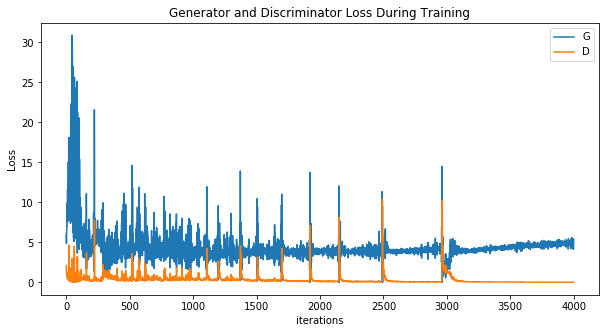

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


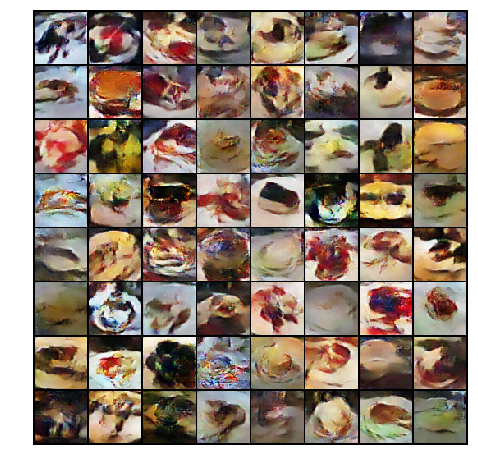

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())